### Automatic Generation of Pseudomodes

We assume we have an environment with a multi-exponential auto-correlation function
$$ C(t) = \sum_k a_k e^{-\nu_k t} . $$
The influence superoperator ("$\mathbf W(\tau)$" in [PM 2024]) has the form
$$ \mathbf W(\tau) = \sum_k \biggl( -\int_0^\tau d\tau'\, \tilde Q(\tau)^\times \tilde Q(\tau')^\rightarrow\, a_k e^{-\nu_k (\tau - \tau')} + \int_0^\tau d\tau'\, \tilde Q(\tau)^\times \tilde Q(\tau')^\leftarrow\, \bar a_k e^{-\bar\nu_k (\tau - \tau')} \biggr) . $$

We make the ansatz of a pseudomode that has the time evolution
$$ \partial_t \rho = \text{[other contributions]} - i\Omega\, [b^\dagger b, \rho] + \Gamma\, \bigl[ b \rho b^\dagger - \{b^\dagger b, \rho\} / 2 \bigr] - i\lambda\, \bigl[ (1 - i\kappa )\, Q X \rho + 2i\kappa\, Q \rho b^\dagger \bigr] + i\lambda\, \bigl[ (1 + i\kappa )\, \rho Q X - 2i\kappa\, b \rho Q \bigr] , $$
based on [Park 2024].
Here, $Q$ is the system coupling operator, $b$ the pseudomode ladder operator and $X = b + b^\dagger$.
$\Omega$ and $\Gamma$ are the frequency and the decay rate of the pseudomode.
For $\kappa = 0$ this reduces to a "regular" pseudomode with coupling constant $\lambda$.
After a tedious calculation, it turns out that this pseudomode makes the following contribution to the influence superoperator:
$$ \mathbf W_{\text{PM}}(\tau) = \lambda^2 \int_0^\tau d\tau'\, \tilde Q(\tau)^\times \tilde Q(\tau')^\rightarrow\, (\kappa+i)^2\, e^{-(\Gamma/2 + i\Omega) t} - \lambda^2 \int_0^\tau d\tau'\, \tilde Q(\tau)^\times \tilde Q(\tau')^\leftarrow\, (\kappa-i)^2\, e^{-(\Gamma/2 - i\Omega) t} . $$

Comparing both expressions, we must satisfy $\nu_k = \Gamma / 2 + i\Omega, \bar\nu_k = \Gamma / 2 - i\Omega$ and $a_k = -\lambda^2 (\kappa + i)^2, \bar a_k = -\lambda^2 (\kappa - i)^2$. Assuming all the parameters are real, this leads to:
\begin{align*}
    \Gamma &= 2\Re(\nu_k) , \\
    \Omega &= \Im(\nu_k) , \\
    \kappa &= \frac{\Re(a_k) \pm |a_k|}{\Im(a_k)} , \\
    \lambda &= \pm \sqrt{-\Im(a_k) / (2\kappa)} .
\end{align*}
There seem to be two choices for $\kappa$. Probably we choose the one with the smaller absolute value?

In [1]:
from collections.abc import Iterable

import numpy as np
import matplotlib.pyplot as plt

import qutip as qt
from qutip.solver.heom import BosonicBath, HEOMSolver

def _tensor(dimensions, opdict, default=None):
    operators = []
    for k, dim_k in enumerate(dimensions):
        if k in opdict:
            operators.append(opdict[k])
        elif default is not None:
            operators.append(default(dim_k))
        else:
            operators.append(qt.qeye(dim_k))
    return qt.tensor(*operators)

def generate_pseudomodes(
    Hsys: qt.Qobj, Q: qt.Qobj, env: qt.ExponentialBosonicEnvironment,
    fock_cutoff: (int | list[int]) = 4
) -> tuple[qt.Qobj, list]:
    # cutoff can be single number or list of numbers corresponding to the exponents
    if isinstance(fock_cutoff, Iterable):
        fock_cutoff = list(fock_cutoff)
    else:
        fock_cutoff = [fock_cutoff] * len(env.exponents)

    dimensions = [Hsys.dims[0]] + fock_cutoff
    Hsys_full = _tensor(dimensions, {0: Hsys})
    Q_full = _tensor(dimensions, {0: Q})

    liouvillian = qt.liouvillian(Hsys_full)

    for k, exponent in enumerate(env.exponents):
        # make PM operators
        b = _tensor(dimensions, {k + 1: qt.destroy(dimensions[k + 1])})
        bd = b.dag()
        X = b + bd

        # determine PM parameters from exponent
        a = exponent.coefficient
        nu = exponent.exponent
        Gamma = 2 * np.real(nu)
        Omega = np.imag(nu)
        if np.imag(a) == 0:
            kappa = 0
            lam = np.sqrt(a + 0j)
        elif np.real(a) > 0:
            kappa = (np.real(a) - np.abs(a)) / np.imag(a)
            lam = np.sqrt(-np.imag(a) / 2 / kappa)
        else:
            kappa = (np.real(a) + np.abs(a)) / np.imag(a)
            lam = np.sqrt(-np.imag(a) / 2 / kappa)

        np.testing.assert_allclose(a, -lam**2 * (kappa + 1j)**2)
        np.testing.assert_allclose(np.conj(a), -lam**2 * (kappa - 1j)**2)

        # construct this PM's contribution to liouvillian
        liouvillian += (
            qt.liouvillian(Omega * bd * b) + Gamma * qt.lindblad_dissipator(b)
            - lam * (1j + kappa) * qt.spre(Q_full * X) + 2 * kappa * lam * qt.sprepost(Q_full, bd)
            + lam * (1j - kappa) * qt.spost(Q_full * X) + 2 * kappa * lam * qt.sprepost(b, Q_full)
        )

    return liouvillian, dimensions


### Example 1 (Underdamped)

In [2]:
Delta = 1
lam = 0.2
gam = 0.25
omega0 = 1
beta = 1

tlist = np.linspace(0, 40, 250)

Hsys = Delta * qt.sigmax() / 2
Q = qt.sigmaz()
initial = qt.qeye_like(Hsys).unit()

env = qt.UnderDampedEnvironment(1 / beta, lam, gam, omega0)
exp_env = env.approx_by_matsubara(Nk=1)

In [3]:
# HEOM solution
solver = HEOMSolver(Hsys, BosonicBath.from_environment(exp_env, Q),
                    max_depth=15, options={'progress_bar': 'html'})
heom_result = solver.run(initial, tlist, e_ops=[Hsys])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# PM solution
pm_liouvillian, pm_dimensions = generate_pseudomodes(Hsys, Q, exp_env, fock_cutoff=[4, 4, 2])

initial_full = _tensor(pm_dimensions, {0: initial}, default=qt.fock_dm)
Hsys_full = _tensor(pm_dimensions, {0: Hsys})

pm_result = qt.mesolve(pm_liouvillian, initial_full, tlist, e_ops=[Hsys_full],
                       options={'progress_bar': 'html'})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

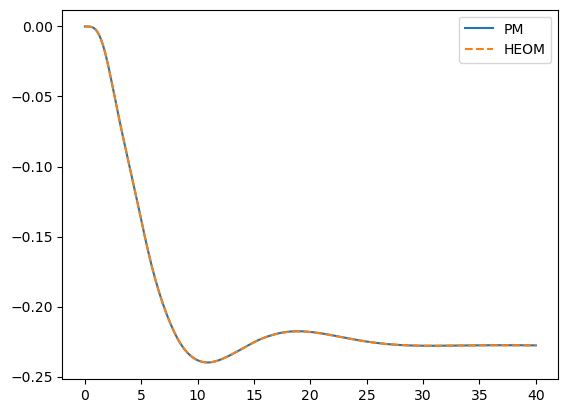

In [5]:
plt.plot(tlist, pm_result.expect[0], label='PM')
plt.plot(tlist, heom_result.expect[0], '--', label='HEOM')
plt.legend()
plt.show()

### Example 2 (Overdamped, dynamical decoupling)

In [6]:
# copied from https://github.com/pmenczel/Pseudomode-Examples/blob/main/example2.ipynb

TLIST = np.linspace(0, 200, 1000)
MAX_STEP = 1 / 40

NUM_MATSUBARA = 3
PM_CUTOFF = [3] * (NUM_MATSUBARA + 2)

HEOM_CUTOFF = 6


V = 1
BETA = 10 / V
GAMMA = 1e-2 * V
LAMBDA = 1e-4 * V

TAU_P = np.pi / (2 * V)
DELTA_T = 10 / V
TAU = DELTA_T + TAU_P


def f(t):
    return V * (np.mod(t, TAU) >= DELTA_T)

Hsys = qt.QobjEvo([qt.sigmax(), f])
Q = qt.sigmaz()
psi0 = (qt.basis(2,1) + qt.basis(2,0)) / np.sqrt(2)
initial = qt.ket2dm(psi0)

env = qt.DrudeLorentzEnvironment(1 / BETA, LAMBDA, GAMMA)
exp_env, _ = env.approx_by_matsubara(Nk=NUM_MATSUBARA)

In [7]:
# HEOM solution
solver = HEOMSolver(
    Hsys, BosonicBath.from_environment(exp_env, Q),
    max_depth=HEOM_CUTOFF, options={'progress_bar': 'html', 'method': 'vern9',
                                    'rtol': 1e-12, 'atol': 1e-12,
                                    'max_step': MAX_STEP, 'nsteps': 1500})
heom_result = solver.run(initial, TLIST, e_ops=[qt.sigmax()])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# PM solution
pm_liouvillian, pm_dimensions = generate_pseudomodes(Hsys, Q, exp_env, fock_cutoff=[3, 3, 2, 2])

initial_full = _tensor(pm_dimensions, {0: initial}, default=qt.fock_dm)
Hsys_full = _tensor(pm_dimensions, {0: Hsys})

pm_result = qt.mesolve(pm_liouvillian, initial_full, TLIST,
                       e_ops=[_tensor(pm_dimensions, {0: qt.sigmax()})],
                       options={'progress_bar': 'html', 'max_step': MAX_STEP})

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

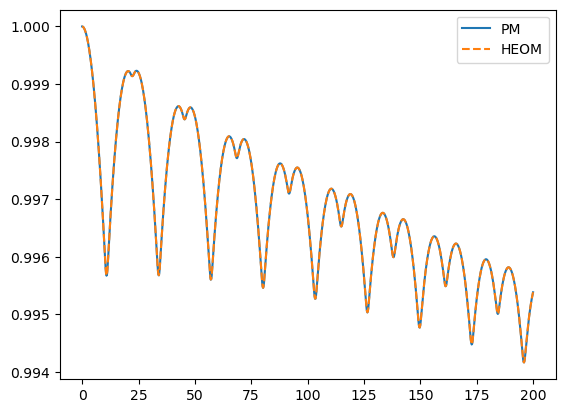

In [9]:
plt.plot(TLIST, pm_result.expect[0], label='PM')
plt.plot(TLIST, heom_result.expect[0], '--', label='HEOM')
plt.legend()
plt.show()